In [1]:
%matplotlib inline

import time

import matplotlib.pyplot as plt
import numpy as onp
import seaborn as sns; sns.set(palette="bright")
import tqdm

import jax.numpy as np
from jax import device_get, jit, random, disable_jit
from jax.config import config; config.update("jax_platform_name", "gpu")
from jax.scipy.special import logit, logsumexp
from jax.tree_util import tree_map, tree_multimap

import numpyro.distributions as dist
from numpyro.distributions.distribution import jax_continuous
from numpyro.handlers import sample, seed, trace
from numpyro.hmc_util import initialize_model
from numpyro.mcmc import hmc
from numpyro.util import control_flow_prims_disabled

In [2]:
num_categories = 3
num_words = 10
num_supervised_data = 100
num_unsupervised_data = 500
rng = random.PRNGKey(1)
rng, rng_transition, rng_emission = random.split(rng, 3)

transition_prior = np.ones(num_categories)
emission_prior = np.repeat(0.1, num_words)

transition_prob = dist.dirichlet.rvs(transition_prior, num_categories, random_state=rng_transition)
emission_prob = dist.dirichlet.rvs(emission_prior, num_categories, random_state=rng_emission)

In [3]:
# simulate data
start_prob = np.repeat(1. / num_categories, num_categories)
categories, words = [], []
for t in range(num_supervised_data + num_unsupervised_data):
    rng, rng_transition, rng_emission = random.split(rng, 3)
    if t == 0 or t == num_supervised_data:
        category = dist.categorical.rvs(start_prob, random_state=rng_transition)
    else:
        category = dist.categorical.rvs(transition_prob[category], random_state=rng_transition)
    word = dist.categorical.rvs(emission_prob[category], random_state=rng_emission)
    categories.append(category)
    words.append(word)
categories, words = np.stack(categories), np.stack(words)

# split into supervised data and unsupervised data
supervised_categories = categories[:num_supervised_data]
supervised_words = categories[:num_supervised_data]
unsupervised_words = categories[num_supervised_data:]

In [4]:
num_warmup_steps = num_samples = 150

### NumPyro

In [5]:
def forward_log_prob(prev_log_prob, curr_word, transition_log_prob, emission_log_prob):
    log_prob = np.expand_dims(prev_log_prob, axis=1) + transition_log_prob
    log_prob = log_prob + emission_log_prob[:, curr_word]
    return logsumexp(log_prob, axis=0)

def semi_supervised_hmm(supervised_categories, supervised_words, unsupervised_words):
    transition_prob = sample("transition_prob", dist.dirichlet(
        np.broadcast_to(transition_prior, (num_categories, num_categories))))
    emission_prob = sample("emission_prob", dist.dirichlet(
        np.broadcast_to(emission_prior, (num_categories, num_words))))

    sample("supervised_categories", dist.categorical(transition_prob[supervised_categories[:-1]]),
           obs=supervised_categories[1:])
    sample("supervised_words", dist.categorical(emission_prob[supervised_categories]),
           obs=supervised_words)

    transition_log_prob = np.log(transition_prob)
    emission_log_prob = np.log(emission_prob)
    log_prob = emission_log_prob[:, unsupervised_words[0]]
    # TODO: to be replaced by lax.scan when its jvp rule is implemented
    for t in range(1, len(unsupervised_words)):
        log_prob = forward_log_prob(log_prob, unsupervised_words[t],
                                    transition_log_prob, emission_log_prob)
    prob = np.clip(np.exp(logsumexp(log_prob, axis=0)), a_min=np.finfo(log_prob.dtype).tiny)
    return sample("forward_prob", dist.bernoulli(prob), obs=1)

In [6]:
init_params, potential_fn, transform_fn = initialize_model(
    random.PRNGKey(2), semi_supervised_hmm,
    (supervised_categories, supervised_words, unsupervised_words), {})
init_kernel, sample_kernel = hmc(potential_fn, algo="NUTS")

hmc_state, wa_state, wa_update = init_kernel(init_params, num_warmup_steps, run_warmup=False)

In [7]:
start = time.time()
jsample_kernel = jit(sample_kernel)
jsample_kernel(hmc_state.update(step_size=10.))
print("time to compile sample_kernel:", time.time() - start)

start = time.time()
jwa_update = jit(wa_update)
jwa_update(t, hmc_state.accept_prob, hmc_state.z, wa_state)
print("time to compile wa_update:", time.time() - start)

start = time.time()
jtransform_fn = jit(transform_fn)
transform_fn(hmc_state.z)
print("time to compile transform_fn:", time.time() - start)

time to compile sample_kernel: 223.43359088897705
time to compile wa_update: 0.33758020401000977
time to compile transform_fn: 0.03674435615539551


In [8]:
for t in tqdm.tqdm(range(num_warmup_steps)):
    hmc_state = jsample_kernel(hmc_state)
    wa_state = jwa_update(t, hmc_state.accept_prob, hmc_state.z, wa_state)
    hmc_state = hmc_state.update(step_size=wa_state.step_size,
                                 inverse_mass_matrix=wa_state.inverse_mass_matrix)

100%|██████████| 150/150 [28:35<00:00,  9.76s/it]


In [9]:
for i in tqdm.tqdm(range(num_samples)):
    hmc_state = jsample_kernel(hmc_state)
    state_out = tree_map(lambda x: np.expand_dims(x, axis=0),
                         {"transition_prob": jtransform_fn(hmc_state.z)["transition_prob"],
                          "num_steps": hmc_state.num_steps})
    if i == 0:
        hmc_states = state_out
    else:
        hmc_states = tree_multimap(lambda x, y: np.concatenate((x, y))
                                   if x is not None else None, hmc_states, state_out)

100%|██████████| 150/150 [43:36<00:00, 20.20s/it]


In [10]:
print(hmc_states["num_steps"].copy())

[ 713 1023  767  661 1023  319   26  255  789 1023 1023 1023 1023  511
  127  255  511 1023 1023  127 1023  255 1023 1023  575  767 1023 1023
  255 1023 1023 1023 1023 1023 1023 1023  511  895 1023  511 1023  127
 1023  816 1023 1023 1023 1023 1023 1023  127 1023  511  127  191 1023
 1023 1023 1023  255 1023  383  127  511  127 1023 1023  383 1023 1023
 1023 1023 1023  639 1023  127 1023 1023  383 1023 1023 1023  831  767
 1023 1023  255  895  895 1023 1023 1023 1023 1023 1023 1023 1023 1023
 1023  639 1023 1023 1023 1023 1023  127 1023 1023 1023 1023 1023 1023
 1023 1023 1023 1023 1023  639 1023 1023 1023  383 1023 1023 1023 1023
 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023 1023
 1023 1023 1023  511  899 1023 1023 1023 1023 1023]


### Stan

In [11]:
import urllib

import pystan

url = "https://raw.githubusercontent.com/stan-dev/example-models/master/misc/hmm/hmm-semisup.stan"
stan_model = urllib.request.urlopen(url).read().decode("utf-8")
print(stan_model)

data {
  int<lower=1> K;  // num categories
  int<lower=1> V;  // num words
  int<lower=0> T;  // num supervised items
  int<lower=1> T_unsup;  // num unsupervised items
  int<lower=1,upper=V> w[T]; // words
  int<lower=1,upper=K> z[T]; // categories
  int<lower=1,upper=V> u[T_unsup]; // unsup words
  vector<lower=0>[K] alpha;  // transit prior
  vector<lower=0>[V] beta;   // emit prior
}
parameters {
  simplex[K] theta[K];  // transit probs
  simplex[V] phi[K];    // emit probs
}
model {
  for (k in 1:K) 
    theta[k] ~ dirichlet(alpha);
  for (k in 1:K)
    phi[k] ~ dirichlet(beta);
  for (t in 1:T)
    w[t] ~ categorical(phi[z[t]]);
  for (t in 2:T)
    z[t] ~ categorical(theta[z[t-1]]);

  { 
    // forward algorithm computes log p(u|...)
    real acc[K];
    real gamma[T_unsup,K];
    for (k in 1:K)
      gamma[1,k] <- log(phi[k,u[1]]);
    for (t in 2:T_unsup) {
      for (k in 1:K) {
        for (j in 1:K)
          acc[j] <- gamma[t-1,j] + log(theta[j,k]) + log(phi[k,u[t]]);
  

In [12]:
%%time
model = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_14c781acf8dbbaa6f89d694cd310dd75 NOW.


CPU times: user 993 ms, sys: 84 ms, total: 1.08 s
Wall time: 49.8 s


In [13]:
%%time
data = {"K": num_categories, "V": num_words, "T": num_supervised_data,
        "T_unsup": num_unsupervised_data, "alpha": transition_prior, "beta": emission_prior,
        "w": supervised_words + 1, "z": supervised_categories + 1, "u": unsupervised_words + 1}
fit = model.sampling(data, chains=1, iter=(num_warmup_steps + num_samples), warmup=num_warmup_steps)

CPU times: user 26.1 s, sys: 62.9 ms, total: 26.1 s
Wall time: 26.1 s


In [14]:
fit.get_sampler_params()[0]["n_leapfrog__"][num_warmup_steps:]

array([ 63.,  63.,  63., 127., 127.,  63.,  63.,  63., 127., 127.,  63.,
       127., 127.,  63.,  63.,  63.,  63., 255., 127.,  63.,  63.,  63.,
        63.,  63.,  63.,  63.,  63.,  39.,  63.,  63.,  63.,  63.,  63.,
        63.,  63.,  69.,  63.,  63.,  63.,  63., 127., 127., 127., 127.,
       127.,  63., 127., 127., 127.,  41., 127., 127.,  63., 127.,   6.,
        14.,  24., 127.,  63., 127.,  63., 127.,  63.,  63., 127., 127.,
        63., 127., 127.,  63., 127.,  63., 127.,  48., 127.,  63.,  63.,
        63.,  63., 127., 127.,  63.,  63.,  63., 127., 127.,  63., 127.,
        63., 127.,  63.,  63.,  63., 127.,  63., 191., 255., 127.,  63.,
       127.,  63.,  63.,  63., 127.,  63.,  63., 127.,  63.,  25.,  47.,
       127.,  63., 127., 127., 127.,  63.,  63.,  56., 255.,  63.,  63.,
        63.,  63.,  63., 127.,  63., 127., 191.,  63.,  63.,  63.,  63.,
        63.,  63.,  63., 127., 127.,  63.,  63.,  63.,  63., 127.,  63.,
       191., 127., 127., 127.,  20., 255.,  63.])

### Plot

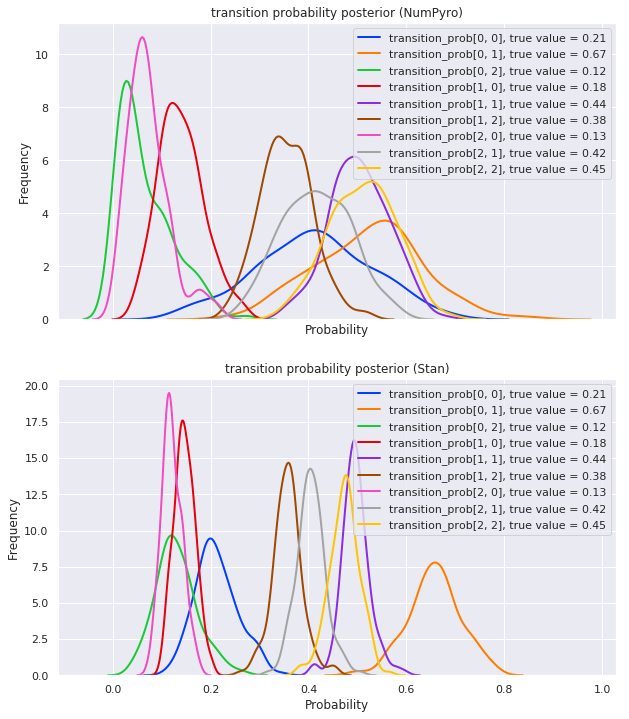

In [15]:
def plot(ax, transition_prob_posterior, title):
    for i in range(num_categories):
        for j in range(num_categories):
            sns.distplot(transition_prob_posterior[:, i, j], hist=False, kde_kws={"lw": 2},
                         label="transition_prob[{}, {}], true value = {:.2f}"
                         .format(i, j, transition_prob[i, j]), ax=ax)
    ax.set(xlabel="Probability", ylabel="Frequency",
           title="transition probability posterior ({})".format(title))

_, (ax1, ax2) = plt.subplots(2, figsize=(10, 12), sharex=True)
plot(ax1, hmc_states["transition_prob"], "NumPyro")
plot(ax2, np.array(fit.extract(pars="theta")["theta"]), "Stan")